In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import levene
from scipy.stats import norm
import seaborn as sns


In [253]:
#loading csv file
df = pd.read_csv("Datasets/Vaccination_Coverage_among_Young_Children__0-35_Months__20241101.csv")

#dropping columns
df = df.drop(columns=['Geography Type'])

#filtering DF again to keep only rows where Dimension Type = 'Age' 
df = df[df['Dimension Type'] == 'Age']

#sorting by vaccine type (column is named 'Vaccine')
df_sorted = df.sort_values (by='Vaccine')

#Displaying the sorted DataFrame
df_sorted

df


,Vaccine,Dose,Geography,Birth Year/Birth Cohort,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size
0,DTaP,≥3 Doses,North Dakota,2019,Age,19 Months,93.5,88.0 to 96.6,263.0
1,DTaP,≥3 Doses,North Dakota,2018,Age,19 Months,95.2,91.0 to 97.5,293.0
2,DTaP,≥3 Doses,North Dakota,2018-2019,Age,19 Months,91.8,88.3 to 94.3,556.0
3,Polio,≥3 Doses,North Dakota,2021,Age,19 Months,89.4,81.9 to 94.1,143.0
4,Polio,≥2 Doses,North Dakota,2021,Age,5 Months,79.3,69.0 to 86.8,143.0
...,...,...,...,...,...,...,...,...,...
128183,Hep A,≥2 Doses,New Hampshire,2021,Age,24 Months,46.7,36.7 to 58.0,126.0
128184,DTaP,≥3 Doses,New Hampshire,2021,Age,19 Months,95.0,90.2 to 97.5,126.0
128185,Hep B,≥3 Doses,New Hampshire,2020-2021,Age,24 Months,95.5,92.5 to 97.5,315.0
128186,PCV,≥3 Doses,New Hampshire,2021,Age,7 Months,70.0,59.6 to 78.7,126.0


In [254]:
# Defining a dictionary to map each state to respective region
#expanding from original 4 regions to 9 regions: 
    #Pacific West, Mountain West, West North Central, East North Central, East South Central 
    # West South Central, South Atlantic, Middle Atlantic, New England
state_to_region = {
    # Middle Atlantic
    'New York': 'Middle Atlantic', 'NY-Rest of state': 'Middle Atlantic', 'NY-City of New York': 'Middle Atlantic', 
    'New Jersey': 'Middle Atlantic', 'Pennsylvania': 'Middle Atlantic', 
    'PA-Philadelphia': 'Middle Atlantic', 'PA-Rest of state': 'Middle Atlantic',

    # New England
    'Vermont': 'New England', 'New Hampshire': 'New England', 'Massachusetts': 'New England', 
    'Connecticut': 'New England', 'Rhode Island': 'New England', 'Maine': 'New England',

    # East North Central
    'Indiana': 'East North Central', 'Illinois': 'East North Central', 'Michigan':'East North Central', 'Ohio': 'East North Central', 
    'Wisconsin': 'East North Central', 'IL-City of Chicago': 'East North Central', 
    'IL-Rest of state': 'East North Central',

    # West North Central
    'Iowa': 'West North Central', 'Kansas': 'West North Central', 'Minnesota': 'West North Central',
    'Missouri': 'West North Central', 'Nebraska': 'West North Central', 'North Dakota': 'West North Central', 
    'South Dakota': 'West North Central',

    #South Atlantic
    'Delaware': 'South Atlantic', 'District of Columbia': 'South Atlantic', 'Florida': 'South Atlantic', 
    'Georgia': 'South Atlantic', 'Maryland': 'South Atlantic', 'North Carolina': 'South Atlantic', 'South Carolina': 'South Atlantic',
    'Virginia': 'South Atlantic', 'West Virginia': 'South Atlantic',

    #East South Central
    'Alabama': 'East South Central', 'Kentucky': 'East South Central', 'Mississippi': 'East South Central', 
    'Tennessee': 'East South Central', 

    #West South Central
    'Arkansas': 'West South Central', 'Louisiana': 'West South Central', 'Oklahoma': 'West South Central', 
    'Texas': 'West South Central', 'TX-City of Houston': 'West South Central', 'TX-Rest of state': 'West South Central',
    'TX-Dallas County': 'West South Central', 'TX-Bexar County':'West South Central', 'TX-El Paso County': 'West South Central',
    'TX-Hidalgo County': 'West South Central', 'TX-Tarrant County':'West South Central',

    #Mountain 
    'Arizona': 'Mountain', 'Colorado': 'Mountain', 'Idaho':'Mountain', 'New Mexico':'Mountain', 
    'Montana': 'Mountain', 'Utah':'Mountain', 'Nevada': 'Mountain', 'Wyoming': 'Mountain',

    #Pacific
    'Alaska': 'Pacific', 'California': 'Pacific', 'Hawaii': 'Pacific', 'Oregon': 'Pacific',
    'Washington': 'Pacific'
}

# Mapping each state in the 'Geography' column to its region
df['Region'] = df['Geography'].map(state_to_region)

# Reordering columns so that 'Region' appears first
df = df[['Region'] + [col for col in df.columns if col != 'Region']]

# Display the updated DataFrame
df



,Region,Vaccine,Dose,Geography,Birth Year/Birth Cohort,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size
0,West North Central,DTaP,≥3 Doses,North Dakota,2019,Age,19 Months,93.5,88.0 to 96.6,263.0
1,West North Central,DTaP,≥3 Doses,North Dakota,2018,Age,19 Months,95.2,91.0 to 97.5,293.0
2,West North Central,DTaP,≥3 Doses,North Dakota,2018-2019,Age,19 Months,91.8,88.3 to 94.3,556.0
3,West North Central,Polio,≥3 Doses,North Dakota,2021,Age,19 Months,89.4,81.9 to 94.1,143.0
4,West North Central,Polio,≥2 Doses,North Dakota,2021,Age,5 Months,79.3,69.0 to 86.8,143.0
...,...,...,...,...,...,...,...,...,...,...
128183,New England,Hep A,≥2 Doses,New Hampshire,2021,Age,24 Months,46.7,36.7 to 58.0,126.0
128184,New England,DTaP,≥3 Doses,New Hampshire,2021,Age,19 Months,95.0,90.2 to 97.5,126.0
128185,New England,Hep B,≥3 Doses,New Hampshire,2020-2021,Age,24 Months,95.5,92.5 to 97.5,315.0
128186,New England,PCV,≥3 Doses,New Hampshire,2021,Age,7 Months,70.0,59.6 to 78.7,126.0


In [255]:
# Filter the DataFrame to only include rows where:
# - 'Vaccine' is 'DTaP' and 'MMR'
# - 'Birth Cohort' is '2020-2021'
# - 'Age Group includes 19 months, 24 months, and 35 months: all ages where it is safely assumed DTaP and MMR 
#    up to Dose 1 can be safely administered)

# Create df_filtered based on conditions in the 'Vaccine' and 'Birth Year/Birth Cohort' columns
df_filtered = df[
    (df['Vaccine'].isin(['DTaP','≥1 Dose MMR'])) &
    (df['Birth Year/Birth Cohort'].isin(['2020-2021', '2020', '2021'])) &
 
   (df['Dimension'].isin(['19 Months','24 Months','35 Months'])) &
   (
        ((df['Vaccine'] == 'DTaP') & (df['Dose'] == '≥4 Doses')) | 
        (df['Vaccine'] == '≥1 Dose MMR')
    )
]

# Rename the column 'Estimate (%)' to 'Estimated Percentage' in df_filtered
df_filtered = df_filtered.rename(columns={'Estimate (%)': 'Estimated_Percentage'})

# Exclude rows where 'Region' , 'Percentage', 'Vaccine' is NaN
df_filtered = df_filtered.dropna(subset=['Region', 'Vaccine', 'Estimated_Percentage'])


df_filtered


,Region,Vaccine,Dose,Geography,Birth Year/Birth Cohort,Dimension Type,Dimension,Estimated_Percentage,95% CI (%),Sample Size
11,West North Central,≥1 Dose MMR,NaN,North Dakota,2021,Age,19 Months,79.9,69.5 to 87.3,143.0
23,West North Central,DTaP,≥4 Doses,North Dakota,2021,Age,35 Months,77.2,67.0 to 86.1,143.0
44,West North Central,≥1 Dose MMR,NaN,North Dakota,2020-2021,Age,35 Months,91.0,85.0 to 95.2,391.0
51,West North Central,DTaP,≥4 Doses,North Dakota,2020-2021,Age,19 Months,68.8,61.8 to 75.1,391.0
65,West North Central,≥1 Dose MMR,NaN,North Dakota,2020-2021,Age,19 Months,83.8,77.6 to 88.5,391.0
...,...,...,...,...,...,...,...,...,...,...
127971,New England,≥1 Dose MMR,NaN,New Hampshire,2020,Age,19 Months,94.4,88.3 to 97.4,189.0
128165,New England,DTaP,≥4 Doses,New Hampshire,2021,Age,24 Months,89.1,80.1 to 95.2,126.0
128168,New England,≥1 Dose MMR,NaN,New Hampshire,2021,Age,24 Months,96.6,93.2 to 98.6,126.0
128172,New England,DTaP,≥4 Doses,New Hampshire,2020-2021,Age,35 Months,94.6,91.2 to 97.1,315.0


In [256]:
# Calculate mean MMR uptake by region
mean_mmr_by_region = df_filtered[
    (df_filtered['Vaccine'] == '≥1 Dose MMR') & 
    (df_filtered['Birth Year/Birth Cohort'] == '2020-2021')
].groupby('Region')['Estimated_Percentage'].mean().reset_index()

# Rename columns for clarity
mean_mmr_by_region.columns = ['Region', 'Mean_MMR_Uptake']
print(mean_mmr_by_region)


               Region  Mean_MMR_Uptake
0  East North Central        91.366667
1  East South Central        89.083333
2     Middle Atlantic        89.266667
3            Mountain        87.954167
4         New England        95.016667
5             Pacific        88.066667
6      South Atlantic        89.722222
7  West North Central        90.947619
8  West South Central        89.685714


In [257]:
import geopandas as gpd

# Load the U.S. states shapefile
shapefile_path = "C:/Users/Kerry Lam/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"  # Update the path to your shapefile
states = gpd.read_file(shapefile_path)

# Map states to Census Regions in the GeoDataFrame
states['Region'] = states['NAME'].map(state_to_region)

# Dissolve states into Census Regions
regions = states.dissolve(by='Region')

# Reset index for easier handling
regions = regions.reset_index()


In [258]:
# Merge the mean MMR uptake data with the regions GeoDataFrame
regions = regions.merge(mean_mmr_by_region, on='Region', how='left')

# Inspect the merged GeoDataFrame
print(regions.head())


               Region                                           geometry  \
0  East North Central  MULTIPOLYGON (((-91.50727 40.20934, -91.50695 ...   
1  East South Central  MULTIPOLYGON (((-88.44913 30.20167, -88.44265 ...   
2     Middle Atlantic  MULTIPOLYGON (((-80.51904 40.95873, -80.519 40...   
3            Mountain  POLYGON ((-103.00196 36.90957, -103.00214 36.7...   
4         New England  MULTIPOLYGON (((-73.62513 40.98121, -73.62681 ...   

  STATEFP   STATENS     AFFGEOID GEOID STUSPS           NAME LSAD  \
0      26  01779789  0400000US26    26     MI       Michigan   00   
1      28  01779790  0400000US28    28     MS    Mississippi   00   
2      42  01779798  0400000US42    42     PA   Pennsylvania   00   
3      16  01779783  0400000US16    16     ID          Idaho   00   
4      25  00606926  0400000US25    25     MA  Massachusetts   00   

          ALAND        AWATER  Mean_MMR_Uptake  
0  146600952990  103885855702        91.366667  
1  121533519481    3926919758 

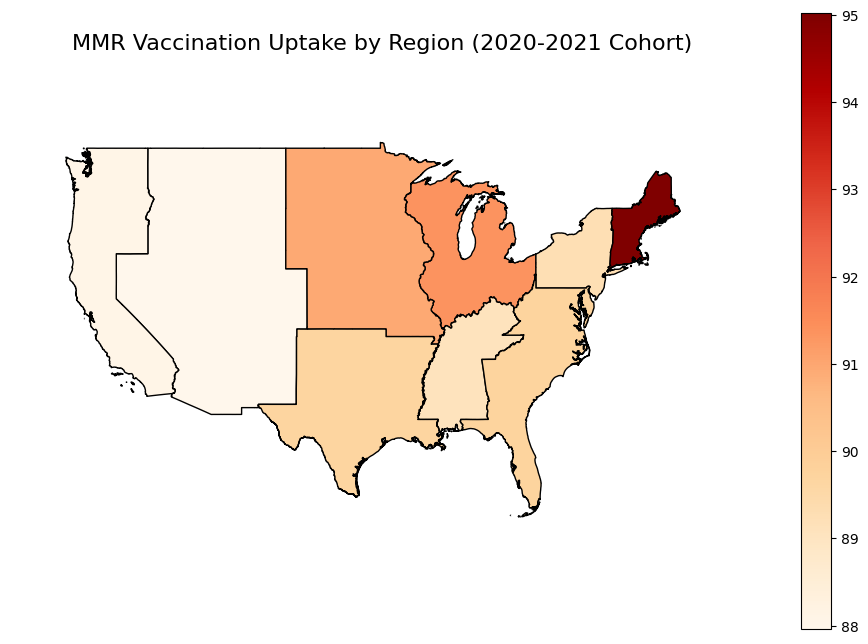

In [259]:
import matplotlib.pyplot as plt

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(12, 8))
regions.plot(
    column='Mean_MMR_Uptake',  # Column to visualize
    cmap='OrRd',              # Colormap
    edgecolor='black',        # Black outline for regions
    legend=True,              # Show legend
    ax=ax                     # Axes object
)

# Add a title
plt.title("MMR Vaccination Uptake by Region (2020-2021 Cohort)", fontsize=16)

# Remove axes for better visualization
plt.axis('off')

ax.set_xlim([-130, -60])  # Longitude for contiguous U.S.
ax.set_ylim([20, 55])     # Latitude for contiguous U.S.


# Show the map
plt.show()


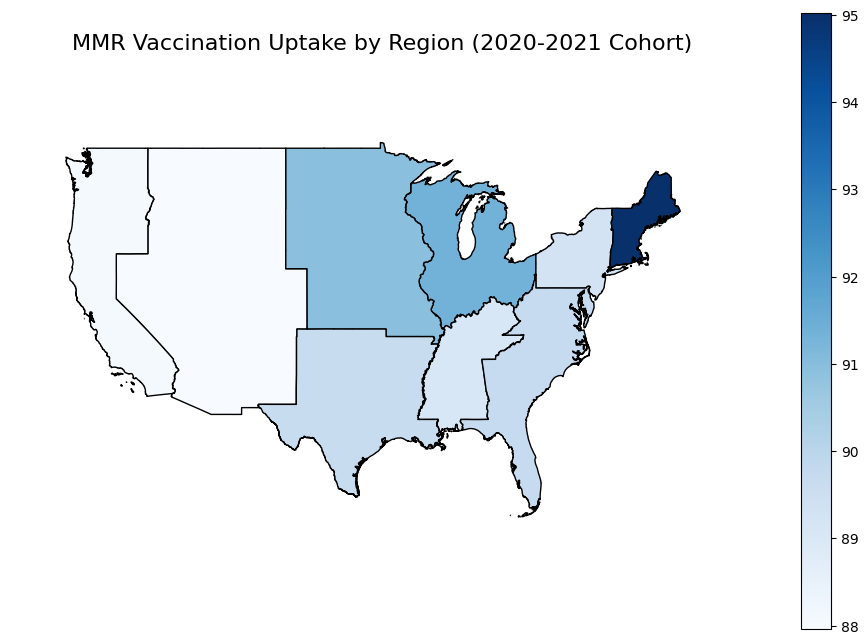

In [262]:
import matplotlib.pyplot as plt

# Plot the blue-themed choropleth map
fig, ax = plt.subplots(figsize=(12, 8))
regions.plot(
    column='Mean_MMR_Uptake',  # Column to visualize
    cmap='Blues',             # Blue colormap
    edgecolor='black',        # Black outline for regions
    legend=True,              # Show legend
    ax=ax                     # Axes object
)

# Add a title
plt.title("MMR Vaccination Uptake by Region (2020-2021 Cohort)", fontsize=16)

# Remove axes for better visualization
plt.axis('off')

ax.set_xlim([-130, -60])  # Longitude for contiguous U.S.
ax.set_ylim([20, 55])     # Latitude for contiguous U.S.

# Show the map
plt.show()
